In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 15
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from matplotlib import pyplot
import datetime
import quandl

# Getting Crude Price data

In [3]:
mydata = quandl.get("FRED/DCOILWTICO", trim_start="2007-11-20", trim_end="2017-11-19",  authtoken="JvvFdXyoMVKhCixW4_WA")
mydata.to_csv("crudeprice.csv")

# Reading data to a dataframe with dates as index

In [4]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('crudeprice.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse, infer_datetime_format=True)
ts = data['Value']
print (data.head())

            Value
Date             
2007-11-20  99.16
2007-11-21  98.57
2007-11-23  98.24
2007-11-26  97.66
2007-11-27  94.39


# Test for Stationarity

### Plotting Rolling Statistics: 
Plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
### Dickey-Fuller Test: 
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the time series is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.
Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be accepted or rejected. The result must be interpreted for a given problem to be meaningful.
### Null Hypothesis (H0): 
If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
### Alternate Hypothesis (H1): 
The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. We interpret this result using the p-value from the test.

A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=5)
    rolstd = pd.rolling_std(timeseries, window=5)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  


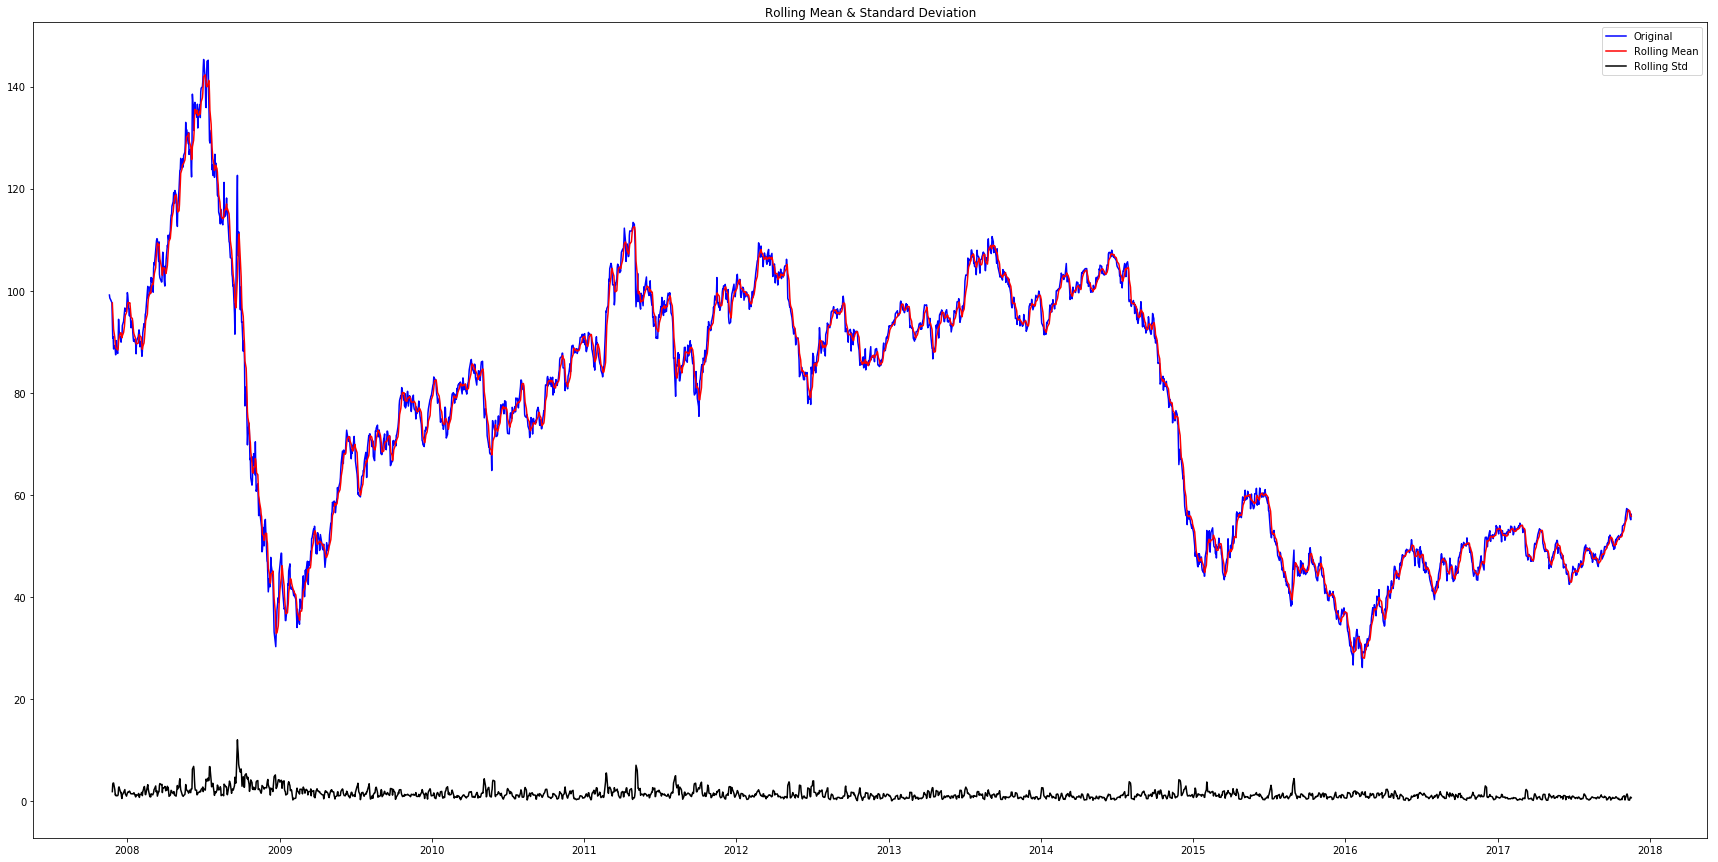

Results of Dickey-Fuller Test:
Test Statistic                   -1.629951
p-value                           0.467516
#Lags Used                        6.000000
Number of Observations Used    2512.000000
Critical Value (1%)              -3.432956
Critical Value (5%)              -2.862691
Critical Value (10%)             -2.567383
dtype: float64


In [15]:
test_stationarity(ts)

We can accept the null-hypothesis to a level. i.e. the series isn't stationary

# Removing Seasonality

### Differencing

Removing peaks in the data.

In [5]:
ts_log = np.log(ts)

In [6]:
ts_log_diff = ts_log - ts_log.shift()

In [7]:
ts_log_diff.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
  


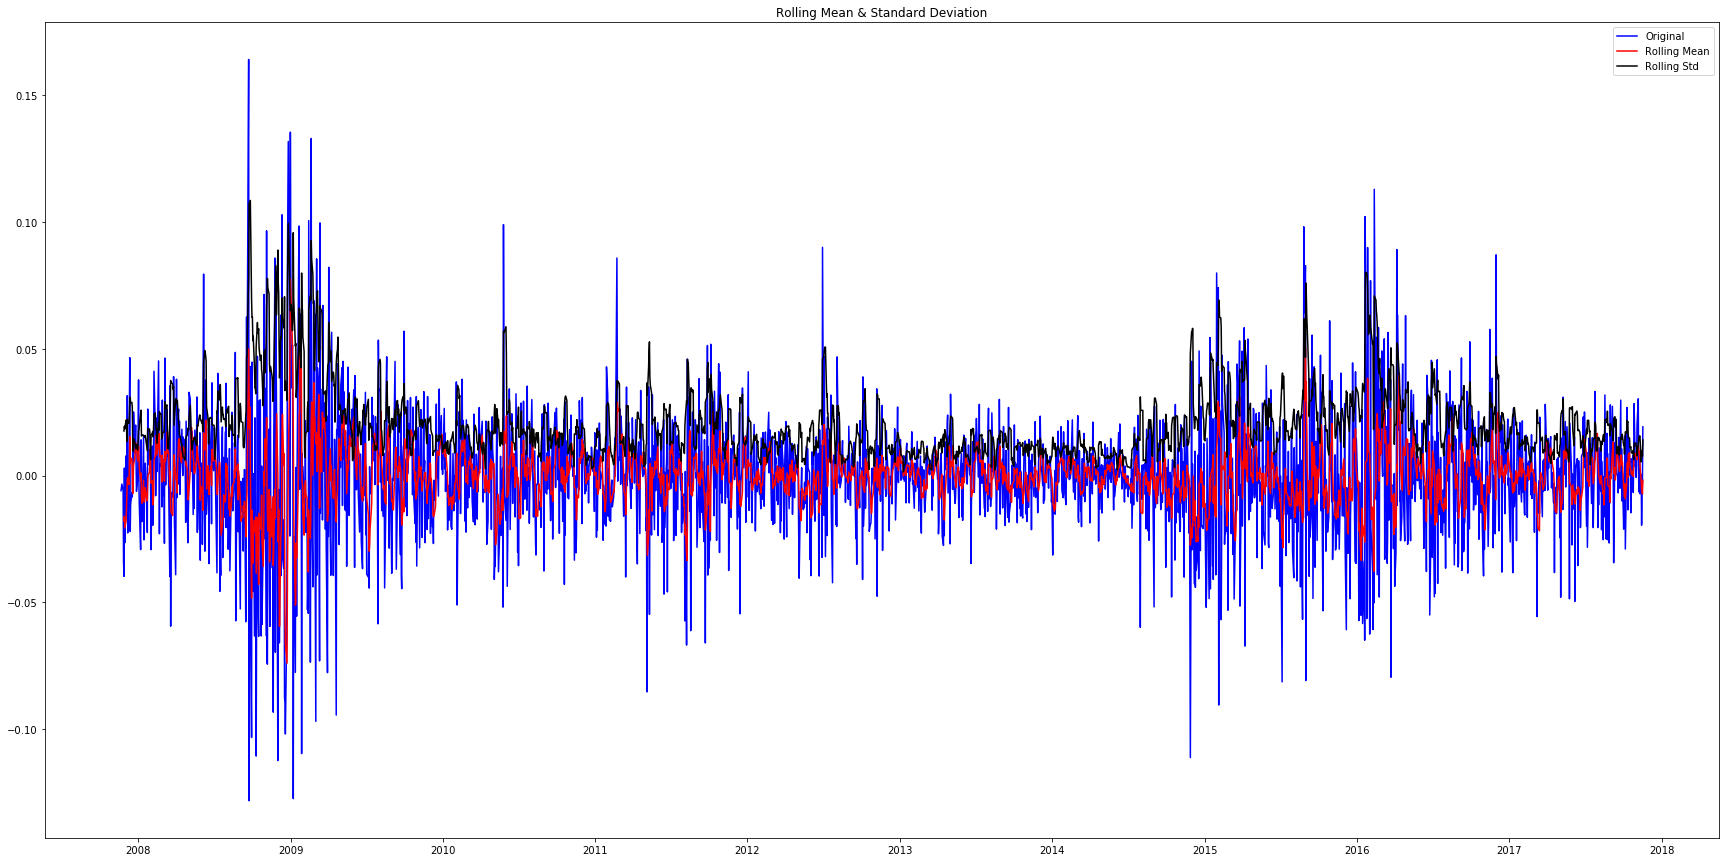

Results of Dickey-Fuller Test:
Test Statistic                -1.311284e+01
p-value                        1.621515e-24
#Lags Used                     1.200000e+01
Number of Observations Used    2.505000e+03
Critical Value (1%)           -3.432963e+00
Critical Value (5%)           -2.862694e+00
Critical Value (10%)          -2.567385e+00
dtype: float64


In [16]:
test_stationarity(ts_log_diff)

As Test Statistic is much lower than Critical Value, according to Dickey-Fuller Test we can say that the series is stationary.

# Deciding parameters for ARIMA(p,d,q) Model

The predictors depend on the parameters (p,d,q) of the ARIMA model:

#### Number of AR (Auto-Regressive) terms (p): 
AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

#### Number of MA (Moving Average) terms (q): 
MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
#### Number of Differences (d): 
These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. 

#### Autocorrelation Function (ACF): 
It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

#### Partial Autocorrelation Function (PACF): 
This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [8]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

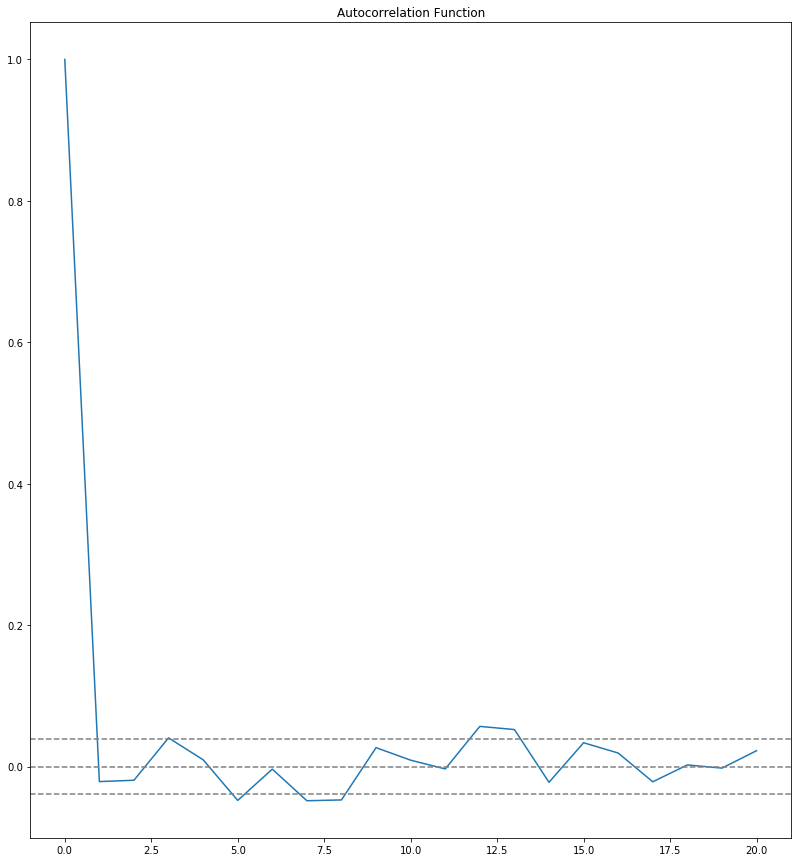

In [9]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

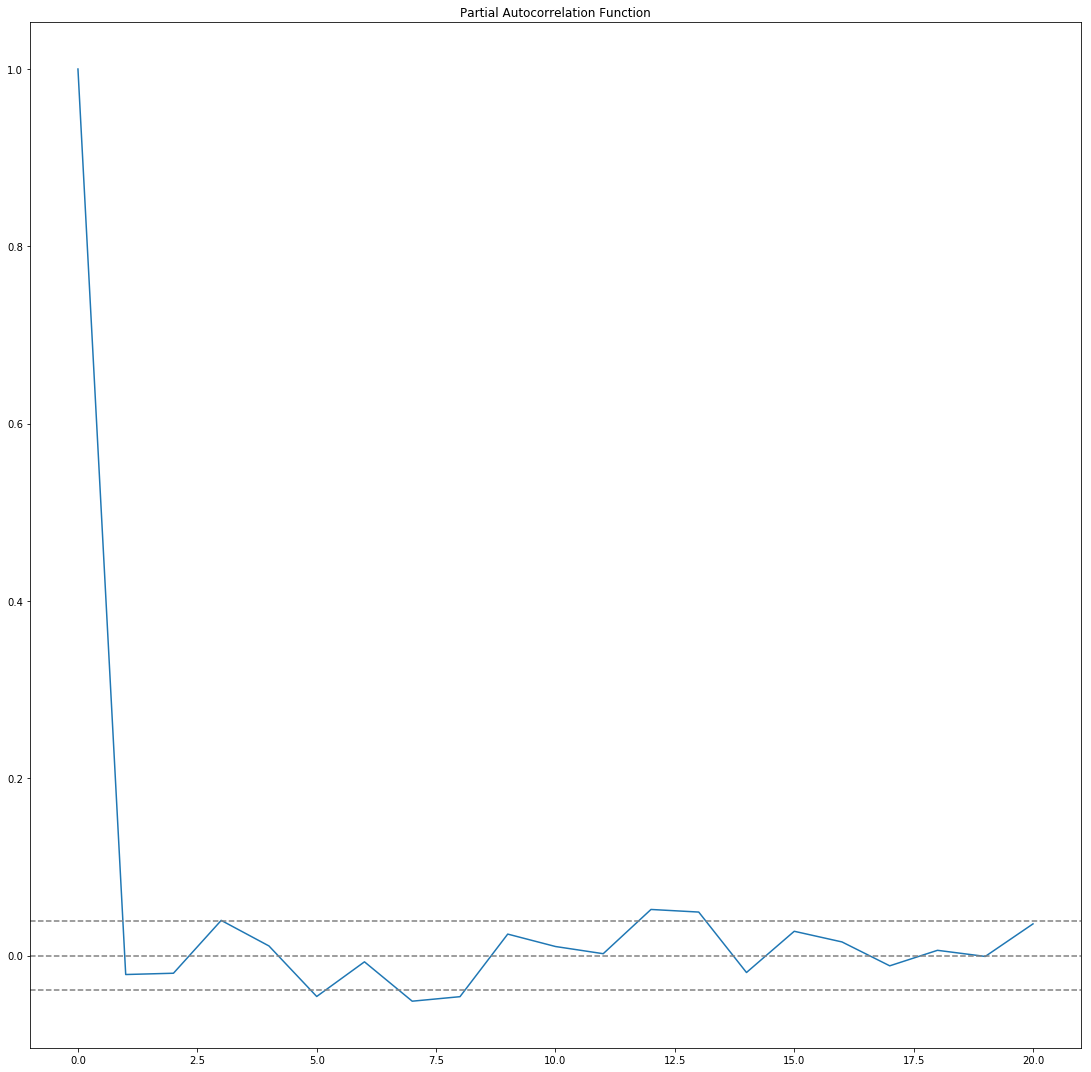

In [10]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### Determining p, q values:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time, being an integer (round off to upper value if not sure). If you notice closely, in this case p=2.

q – The lag value where the ACF chart crosses the upper confidence interval for the first time, being an integer (round off to upper value if not sure). If you notice closely, in this case q=2.

# Predicting the last value in the data

In [11]:
X = ts.values
size = len(X) - 1
train, test = X[0:size], X[size:]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast()
print('Expected: %.3f' % test[0])
print('Forecast: %.3f' % forecast)
print('Standard Error: %.3f' % stderr)
print('95%% Confidence Interval: %.3f to %.3f' % (conf[0][0], conf[0][1]))

Expected: 56.210
Forecast: 55.118
Standard Error: 1.728
95% Confidence Interval: 51.730 to 58.505


Confidence level determines the band in which we can safely say the predicted and actual values can lie.

In [12]:
X = ts.values
size = len(X) - 1
train, test = X[0:size], X[size:]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit(disp=False)
intervals = [0.2, 0.1, 0.05, 0.01]
for a in intervals:
	forecast, stderr, conf = model_fit.forecast(alpha=a)
	print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))

80.0% Confidence Interval: 55.118 between 52.903 and 57.333
90.0% Confidence Interval: 55.118 between 52.275 and 57.961
95.0% Confidence Interval: 55.118 between 51.730 and 58.505
99.0% Confidence Interval: 55.118 between 50.666 and 59.570


# Predictions for the next 5 days

In [13]:
X = ts.values
last_date = data.index[-1] + datetime.timedelta(days=1)
window = 5
model = ARIMA(X, order=(2,1,2))
model_fit = model.fit(disp=False)
forecast, stderr, conf = model_fit.forecast(alpha=0.01)
X = np.append(X, forecast)
predictions = {}
print('Expected: %.3f' % X[-1])
print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))
predictions[str(last_date.date())] = (conf[0][0], conf[0][1], forecast[0])

for t in range(window):
    last_date = last_date + datetime.timedelta(days=1)
    model = ARIMA(X, order=(2,1,2))
    model_fit = model.fit(disp=False)
    forecast, stderr, conf = model_fit.forecast(alpha=0.01)
    X = np.append(X, forecast)
    print('%.1f%% Confidence Interval: %.3f between %.3f and %.3f' % ((1-a)*100, forecast, conf[0][0], conf[0][1]))
    predictions[str(last_date.date())] = (conf[0][0], conf[0][1], forecast[0])
    

Expected: 56.170
99.0% Confidence Interval: 56.170 between 51.718 and 60.622
99.0% Confidence Interval: 56.145 between 51.694 and 60.596
99.0% Confidence Interval: 56.149 between 51.699 and 60.599
99.0% Confidence Interval: 56.140 between 51.691 and 60.589
99.0% Confidence Interval: 56.104 between 51.656 and 60.552
99.0% Confidence Interval: 56.079 between 51.631 and 60.526


In [58]:
predictions

{'2017-11-18': (51.718117777696435, 60.621537550227089, 56.169827663961762),
 '2017-11-19': (51.693954172237717, 60.595606513694428, 56.144780342966072),
 '2017-11-20': (51.699007955627224, 60.598893916830747, 56.148950936228985),
 '2017-11-21': (51.69098560917076, 60.589106239937742, 56.140045924554251),
 '2017-11-22': (51.655574259753763, 60.551930618909225, 56.103752439331494),
 '2017-11-23': (51.631403045858221, 60.525996181181441, 56.078699613519831)}